In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def gen_grid2d(grid_size: int, left_end: float=-1, right_end: float=1) -> torch.Tensor:
    """
    Generate a grid of size (grid_size, grid_size, 2) with coordinate values in the range [left_end, right_end]
    """
    x = torch.linspace(left_end, right_end, grid_size)
    x, y = torch.meshgrid([x, x], indexing='ij')
    grid = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), dim=1).reshape(grid_size, grid_size, 2)
    return grid

In [28]:
g2 = gen_grid2d(32)
g2.shape

torch.Size([32, 32, 2])

In [5]:
g2[0][0]

tensor([-1., -1.])

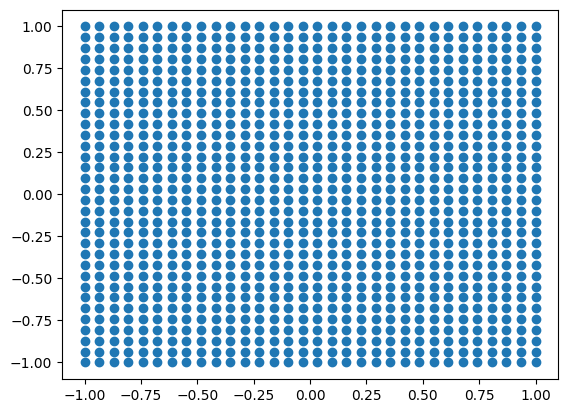

In [6]:
plt.scatter(g2[:,:,0], g2[:,:,1])

In [29]:
def gen_grid3d(grid_size: int, left_end: float=-1, right_end: float=1) -> torch.Tensor:
    """
    Generate a grid of size (grid_size, grid_size, grid_size, 3) with coordinate values in the range [left_end, right_end]
    """
    x = torch.linspace(left_end, right_end, grid_size)
    x, y, z = torch.meshgrid([x, x, x], indexing='ij')
    grid = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1).reshape(grid_size, grid_size, grid_size, 3)
    return grid

In [30]:
g= gen_grid3d(16)
g.shape

torch.Size([16, 16, 16, 3])

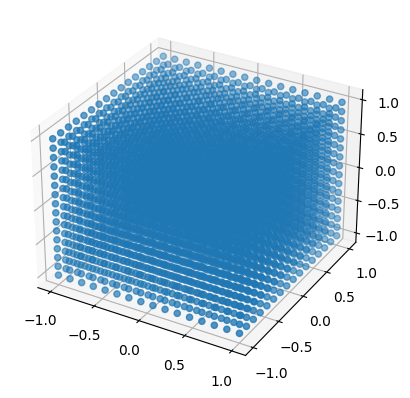

In [9]:
# Plot the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g[:, :, :, 0], g[:, :, :, 1], g[:, :, :, 2])
plt.show()

In [2]:
from PIL import Image
from torchvision import transforms


In [65]:
x = Image.open('img.png')
np.array(x).shape

(128, 128, 4)

In [68]:
transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.RandomHorizontalFlip(p=0.0), # TODO change to 0.5?
            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)),
        ])

In [69]:
x = transform(x)
x = x.unsqueeze(0)

In [70]:
x.shape

torch.Size([1, 4, 128, 128])

In [64]:
# x = x.repeat(2, 1, 1, 1).shape

In [76]:
import torch.nn as nn
import torch

model = nn.Sequential(
    nn.Conv2d(4, 8 * 16, kernel_size=3, padding=1),
    nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
    # nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
    # nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
    torch.nn.Unflatten(1, (8,16)),
    # nn.Conv3d(16, 8, kernel_size=3, stride=1, padding=1),
    # nn.ReLU()
)

# Define the input tensor
# x = torch.randn(2, 3, 128, 128)

# Pass the input tensor through the model
output = model(x)

# output = output.unsqueeze(-1)


# Print the output tensor shape
print(output.shape) # Should print: torch.Size([1, 8, 32, 32, 32])


torch.Size([1, 8, 16, 64, 64])


In [77]:
output[0][0].shape

torch.Size([16, 64, 64])

In [78]:
from einops import rearrange

In [79]:
out_img = rearrange(output[0][0], 'c h w -> h w c')
out_img.shape

torch.Size([64, 64, 16])

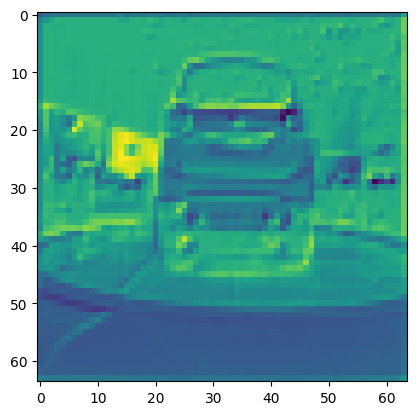

In [80]:
plt.imshow(out_img[:,:,:1].detach().numpy())

In [48]:
out_img = transforms.ToPILImage()(output.squeeze(0)[0][:1])
np.array(out_img).shape

(16, 8)

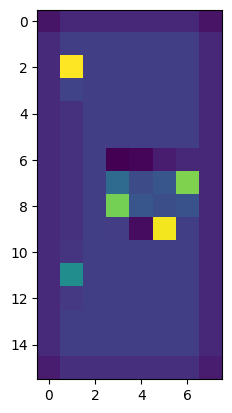

In [44]:
plt.imshow(out_img)

In [32]:
output[0][0].permute(2,1,0)[:,:,0].shape

torch.Size([8, 16])

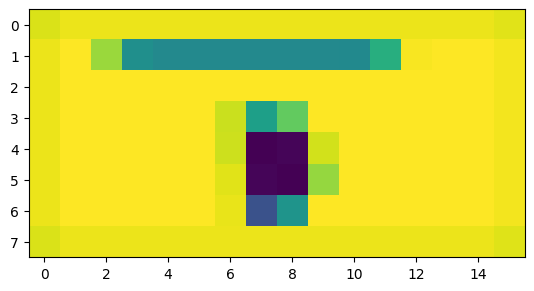

In [36]:
# [b,c,w,h] -> [b,w,h,c]
plt.imshow(output[0][0].permute(2,1,0)[:,:,0].detach().numpy())

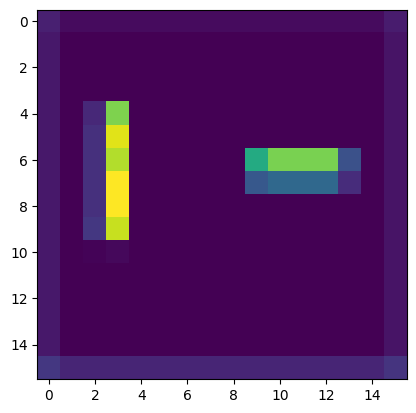

In [84]:
plt.imshow(output[0][0].sum(axis=0).detach().numpy().transpose(0,1))

In [67]:
import torch.nn.functional as F

In [68]:
prob_map = output.reshape(1,8,-1,1)
print(prob_map.shape)
prob_map = F.softmax(prob_map, dim=2)
print(prob_map.shape)

torch.Size([1, 8, 4096, 1])
torch.Size([1, 8, 4096, 1])


In [69]:
grid = g.reshape(1, 1, 16 ** 3, 3)
coord = nn.Parameter(grid, requires_grad=False)
coord.shape

torch.Size([1, 1, 4096, 3])

In [70]:
keypoints = coord * prob_map
keypoints = keypoints.sum(dim=2)
keypoints.shape

torch.Size([1, 8, 3])

In [71]:
pts = keypoints[0].detach().numpy()

In [90]:
pts

array([[-0.01767115,  0.00086784, -0.00075365],
       [-0.07477729,  0.00229835,  0.00132812],
       [ 0.11711243,  0.0011608 ,  0.00124758],
       [-0.00434409,  0.00237239,  0.00180144],
       [ 0.02423477,  0.00143652,  0.00104648],
       [-0.05206422,  0.00332861,  0.00268009],
       [-0.01047052,  0.00215455,  0.00261478],
       [ 0.00506739, -0.00079423, -0.00169107]], dtype=float32)

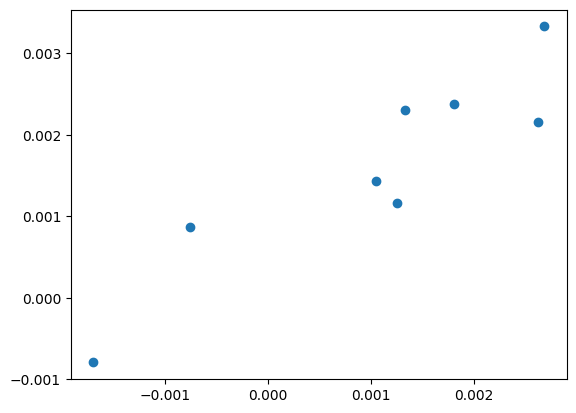

In [92]:
plt.scatter(pts[:,2], pts[:,1])

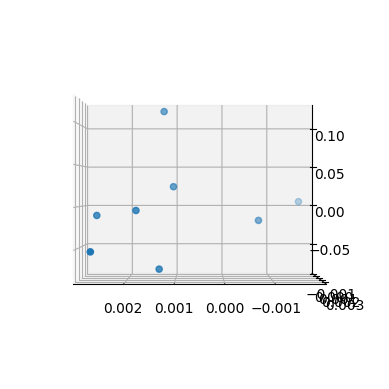

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,2], pts[:,1], pts[:,0])
ax.view_init(elev=0, azim=90, roll=0)

plt.show()

In [11]:
x = torch.randn(16,16,16,3)
x.reshape(1,1,-1,3).shape

torch.Size([1, 1, 4096, 3])

In [12]:
32**3

32768

In [13]:
import matplotlib.pyplot as plt

In [16]:
# a = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
a = np.array([[0,1,0,0],[0,0,1,0],[0,0,0,1]])
a2 =  np.array([[0,1.2,0,0],[0,0,1.2,0],[0,0,0,1.2]])

NameError: name 'a' is not defined

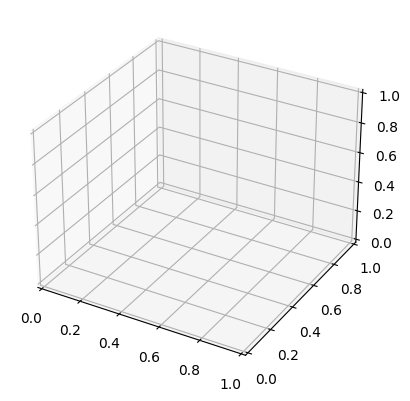

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0], a[:,1], a[:,2])
ax.scatter(a2[:,0], a2[:,1], a2[:,2])

plt.show()

In [18]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    https://stackoverflow.com/questions/6802577/rotation-of-3d-vector
    https://www.programcreek.com/python/?CodeExample=get+rotation+matrix
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                    [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                    [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [19]:
import numpy as np
import math

In [33]:
# v = [3, 5, 0]
axis = [0,0,1]
theta = 1.2 

a_coord = [a[:,0], a[:,1], a[:,2],a[:,3]]
a_coord

a_rot = [np.dot(rotation_matrix(axis, math.degrees(6)), v) for v in a_coord]
a_rot

[array([0., 0., 0.]),
 array([-0.22770342, -0.97373053,  0.        ]),
 array([ 0.97373053, -0.22770342,  0.        ]),
 array([0., 0., 1.])]

In [34]:
xs = [v[0] for v in a_rot]
ys = [v[1] for v in a_rot]
zs = [v[2] for v in a_rot]

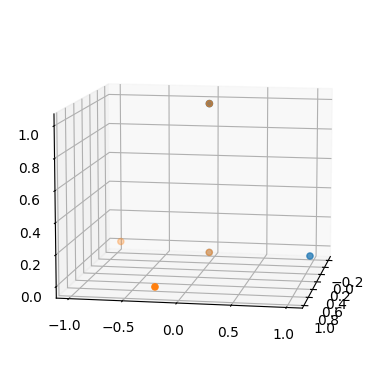

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0], a[:,1], a[:,2])
ax.scatter(xs, ys, zs)

ax.view_init(elev=10, azim=10, roll=0)

plt.show()

In [36]:
from scipy.spatial.transform import Rotation as R


In [43]:
a = a-0.5


In [45]:
a_coord = [a[:,0], a[:,1], a[:,2],a[:,3]]
a_coord

[array([-0.5, -0.5, -0.5]),
 array([ 0.5, -0.5, -0.5]),
 array([-0.5,  0.5, -0.5]),
 array([-0.5, -0.5,  0.5])]

In [46]:
r = R.from_rotvec(10 * np.array([0, 0, 1]), degrees=True)
r.as_matrix()

array([[ 0.98480775, -0.17364818,  0.        ],
       [ 0.17364818,  0.98480775,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [47]:
a_coord

[array([-0.5, -0.5, -0.5]),
 array([ 0.5, -0.5, -0.5]),
 array([-0.5,  0.5, -0.5]),
 array([-0.5, -0.5,  0.5])]

In [48]:
a_rot = [r.apply(v) for v in a_coord]
a_rot

[array([-0.40557979, -0.57922797, -0.5       ]),
 array([ 0.57922797, -0.40557979, -0.5       ]),
 array([-0.57922797,  0.40557979, -0.5       ]),
 array([-0.40557979, -0.57922797,  0.5       ])]

In [49]:
xs = [v[0] for v in a_rot]
ys = [v[1] for v in a_rot]
zs = [v[2] for v in a_rot]

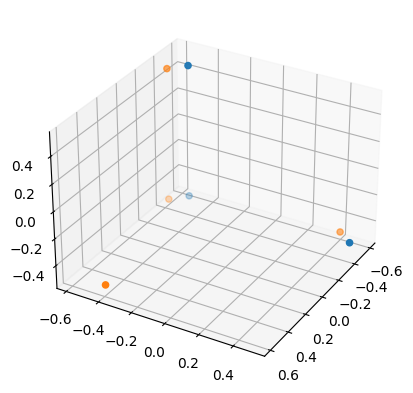

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a[:,0], a[:,1], a[:,2])
ax.scatter(xs, ys, zs)

ax.view_init(elev=30, azim=30, roll=0)

plt.show()